Changes to be made:
1. Digitize the signal with a uniform Probability distribution between -1 and 1 (0 and 1 seems better but -1 and 1 is used here)
2. Apply Jakes filter (haven't changed the implementation of this, don't see a reason to as of now)
3. AWGN noise
4. LS separation using y = hx + n --- y/h = x + n/h, given n is very small (high SNR) approximate h for the packet, given x of the header and y. This has changed since the last implementation where I used y = Ax + n, given A = I, approximate a good x - not right
5. Divide packet values by the h found and find MSE, bit error rate and correlation of original and predicted signal

Note: during prediction, the channel value is taken to be constant over each packet, but during transmission it is to be sampled form the Jakes distribution for every point, not just for every packet
 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import copy
from scipy import signal as sp
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [27]:
# Generate a digital signal
def generate_digital_signal(length):
    return np.random.choice([-1, 1], size=length)

In [29]:
# Generate Rayleigh channel envelope
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

def generate_rayleigh_envelope(signal_length, num_packets):
    fd = 100 #Doppler frequency
    Fs = 10000 #Sampling frequency
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N) #Jakes filter
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h, 'valid')
    return y


In [95]:
def apply_rayleigh_fading(signal, y):
    signal2 = copy.deepcopy(signal)
    for i in range(len(signal2)):
        signal2[i] *= y[i]
    return signal2, y[:len(signal2)]

In [33]:
def add_awgn_noise(signal, snr_db):
    snr = 10 ** (snr_db / 10)
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

In [35]:
# Estimate h using least squares - we neglect n/h since it is very low
def estimate_h(x_known, y):
    return lstsq(x_known.reshape(-1, 1), y)[0][0]


In [37]:
# Divide packet values by estimated h
def apply_channel_estimation(signal, h_estimates):
    signal2 = copy.deepcopy(signal)
    packet_size = len(signal2) // len(h_estimates)  # Assuming signal length is a multiple of h_estimates length
    for i in range(len(h_estimates)):
        start_idx = i * packet_size
        end_idx = start_idx + packet_size
        signal2[start_idx:end_idx] /= h_estimates[i]
    return signal2

In [39]:
# Digitize the signal
def digitize(signal):
    return np.where(signal >= 0, 1, -1)

In [41]:
def plot_results(original_x, y, estimated_x):
    # Plot original and predicted x
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Original signal
    ax1.plot(original_x[:512], label='Original x')
    ax1.set_title('Original Signal')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    # Estimated signal
    ax2.plot(estimated_x[:512], label='Estimated x', color='orange')
    ax2.set_title('Estimated Signal')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot noisy x (y)
    plt.figure(figsize=(12, 6))
    plt.plot(y[:512], label='y (scaled and noisy)', color = "g")
    plt.legend()
    plt.title('Noisy Signal (y)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()


In [97]:
# Function to run the entire process
def run_signal_processing():
    # Parameters
    signal_length = 51200
    packet_size = 256
    num_packets = 200
    header_size = 16
    snr_db = 10 * np.log10(1000)

    original_signal = generate_digital_signal(signal_length)
    rayleigh_envelope = generate_rayleigh_envelope(signal_length, num_packets)
    
    faded_signal, actual_h = apply_rayleigh_fading(original_signal, rayleigh_envelope)
    noisy_signal = add_awgn_noise(faded_signal,1000)
    
    
    #LS estimation
    packets = [original_signal[i:i + packet_size] for i in range(0, signal_length, packet_size)]
    noisy_packets = [noisy_signal[i:i + packet_size] for i in range(0, signal_length, packet_size)]
    h_estimates = [estimate_h(packet[:header_size], noisy_packet[:header_size]) for packet, noisy_packet in zip(packets, noisy_packets)]
    estimated_signal = apply_channel_estimation(noisy_signal, h_estimates)

    estimated_signal2 = copy.deepcopy(estimated_signal)
    for i in range(len(estimated_signal2)):
        if estimated_signal[i]>0:
            estimated_signal[i] = 1
        else:
            estimated_signal[i] = -1
    # Plotting
    plot_results(original_signal, noisy_signal, estimated_signal)
    
    # Calculate MSE
    mse = mean_squared_error(original_signal, estimated_signal)
    print(f"Mean Squared Error (MSE): {mse}")

    # Calculate correlation
    correlation = np.corrcoef(original_signal, estimated_signal)[0, 1]
    print(f"Correlation: {correlation}")
    
    return original_signal, noisy_signal, estimated_signal, faded_signal, h_estimates, actual_h

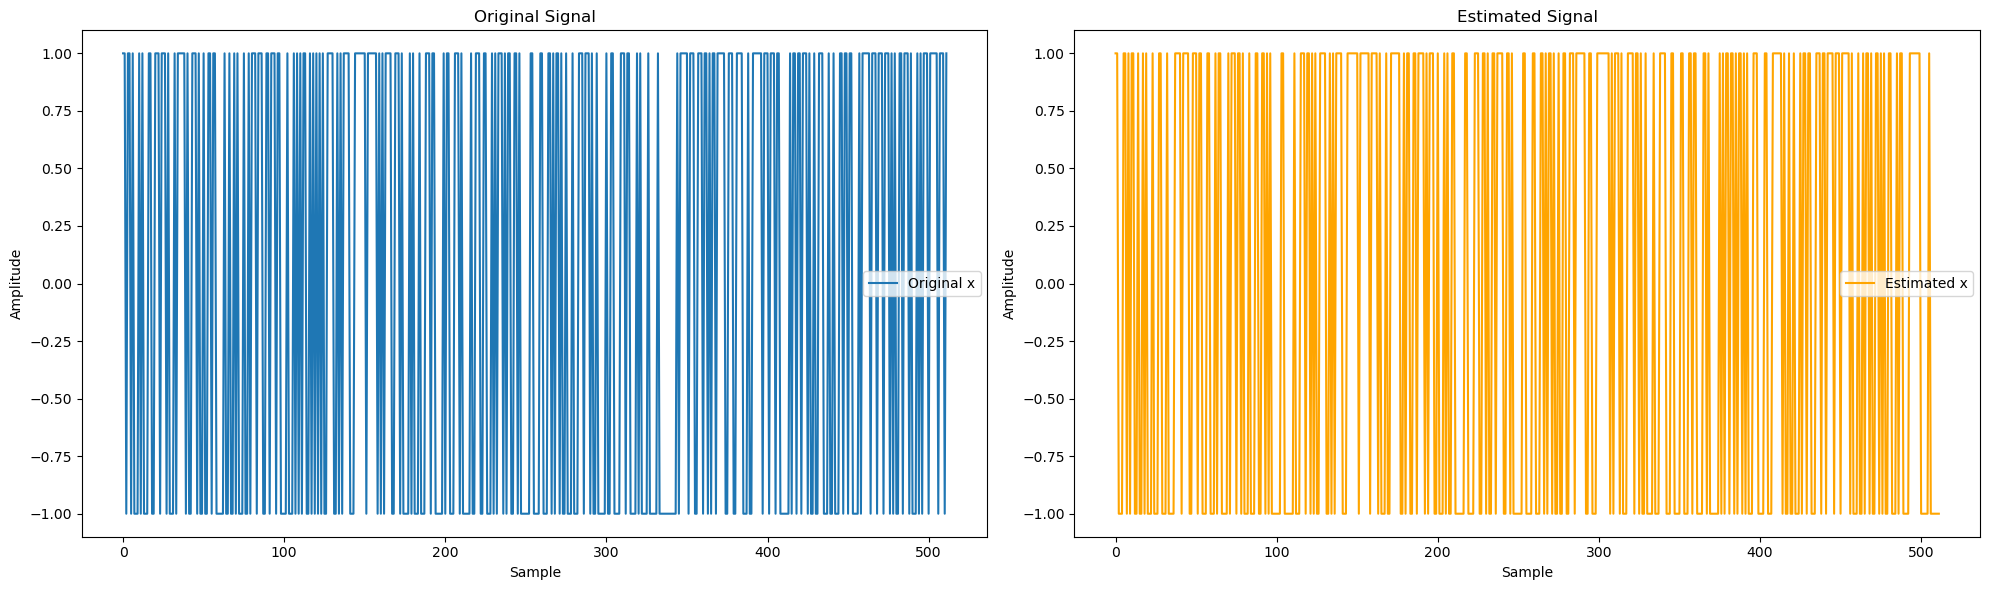

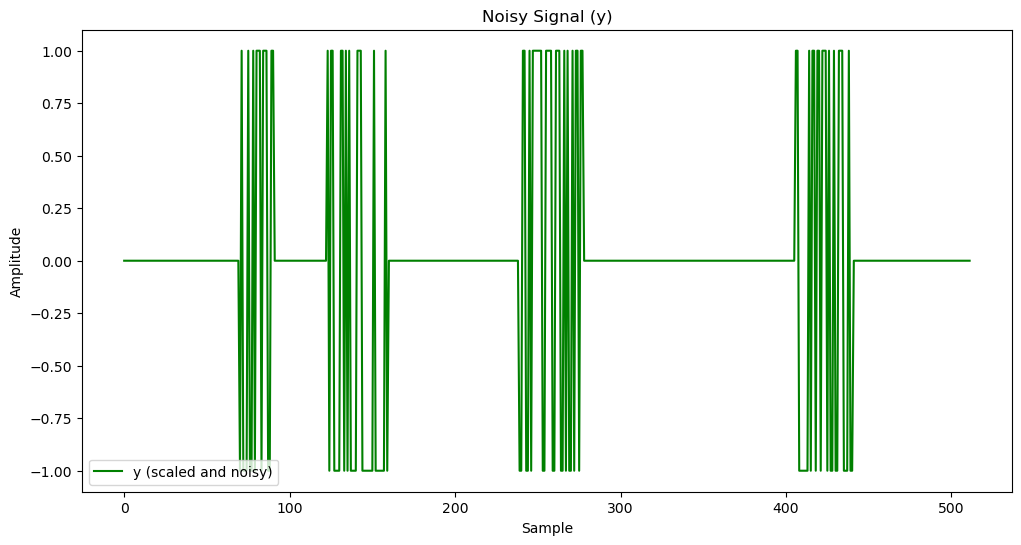

Mean Squared Error (MSE): 1.9328125
Correlation: 0.03361641524278774


In [99]:
# Run the entire process
original_x, y, estimated_x, just_h_y, h_estimates, actual_h = run_signal_processing()

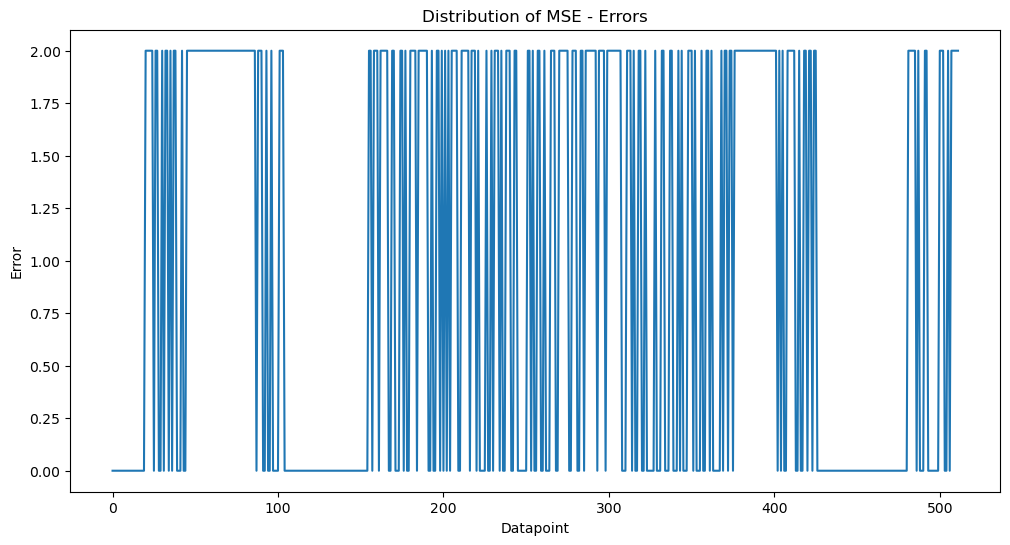

In [83]:
error = (((estimated_x - original_x)**2)/2)[:512]
plt.figure(figsize=(12, 6))
plt.plot(error)
plt.title('Distribution of MSE - Errors')
plt.xlabel('Datapoint')
plt.ylabel('Error')
plt.show()

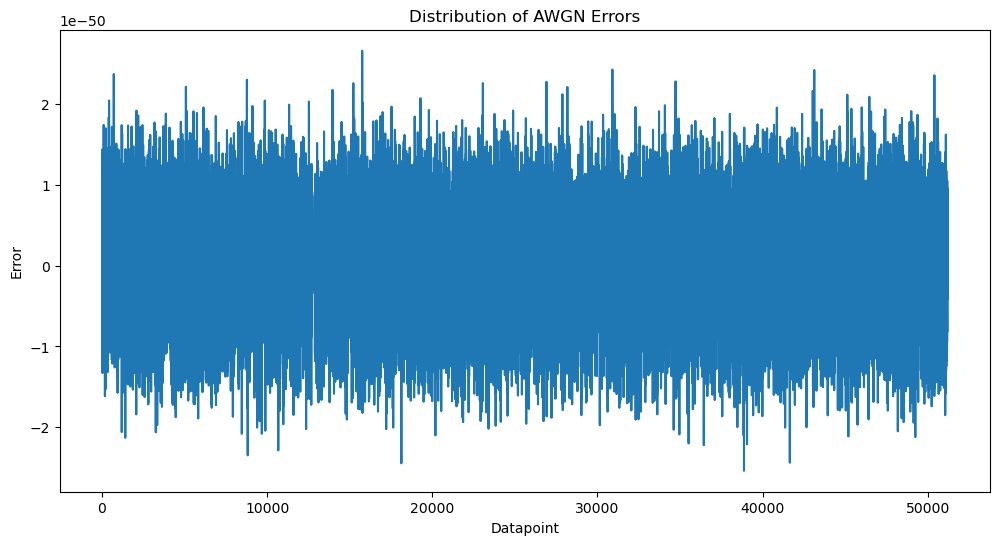

In [85]:
error_y = just_h_y - y
plt.figure(figsize=(12, 6))
plt.plot(error_y)
plt.title('Distribution of AWGN Errors')
plt.xlabel('Datapoint')
plt.ylabel('Error')
plt.show()

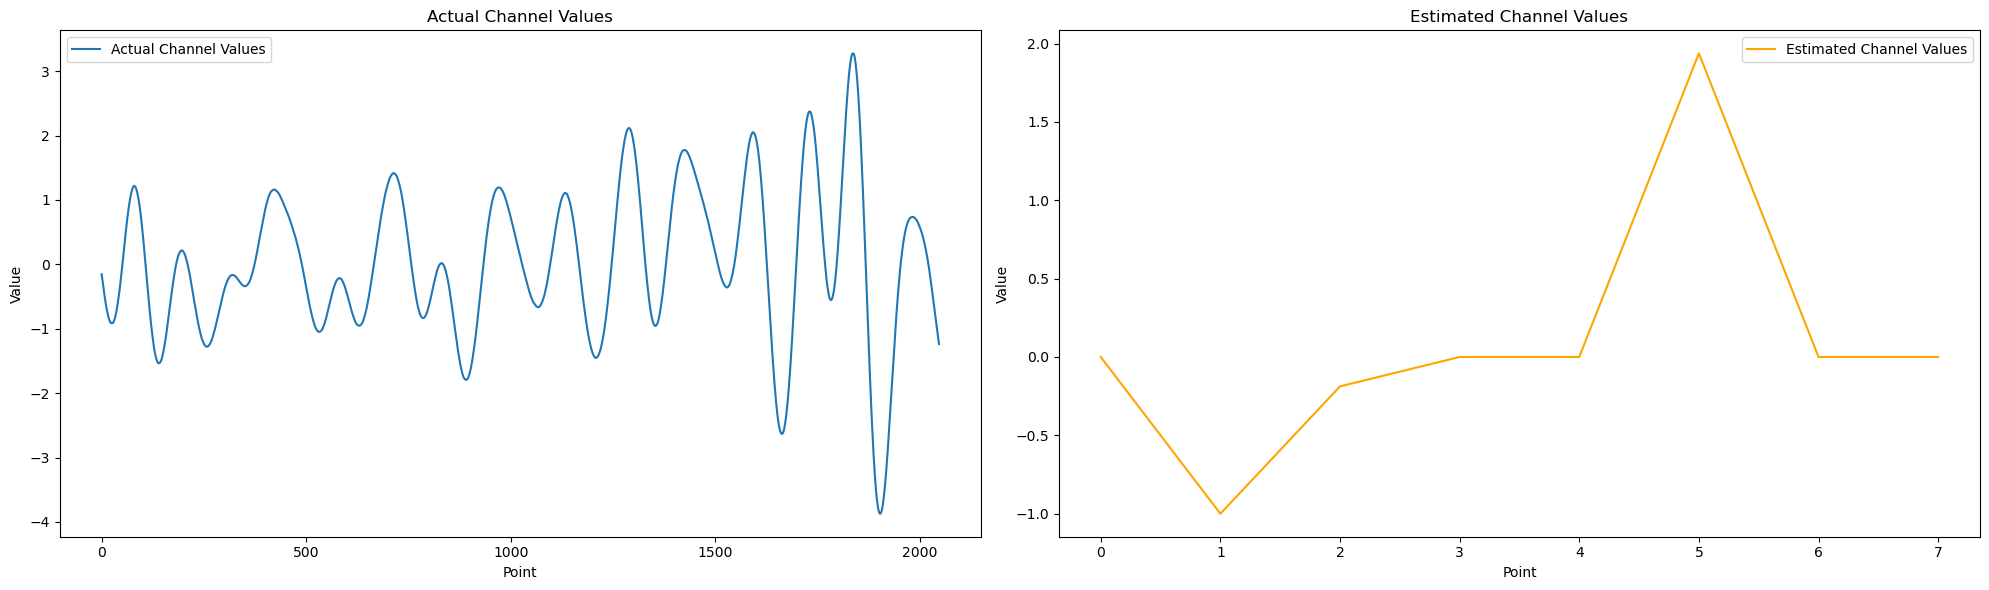

In [105]:
#Plot of actual and predicted channel values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
# Original signal
ax1.plot(actual_h[:2048], label='Actual Channel Values')
ax1.set_title('Actual Channel Values')
ax1.set_xlabel('Point')
ax1.set_ylabel('Value')
ax1.legend()

# Estimated signal
ax2.plot(h_estimates[:8], label='Estimated Channel Values', color='orange')
ax2.set_title('Estimated Channel Values')
ax2.set_xlabel('Point')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

In [87]:
def calculate_ber_with_threshold(original_signal, estimated_signal):
    # Ensure the signals are the same length
    assert len(original_signal) == len(estimated_signal)
    correct = 0
    for i in range(len(original_signal)):
        if original_signal[i]*estimated_signal[i]>0: #Checking if they are of the same sign
            correct += 1
    ber = 1- (correct/len(original_signal)) #Tells us the fraction of bits predicted incorrectly
    
    return ber

ber = calculate_ber_with_threshold(original_x, estimated_x)
print(f"Bit Error Rate (BER) with threshold: {ber:.9f}")

Bit Error Rate (BER) with threshold: 0.475996094
